In [1]:
%matplotlib inline

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'src/')))
from sgpi.plot import *
from sgpi.util import group_list
from sgpi.mnist import *

import numpy as np; np.random.seed(42)

import pandas as pd
import pysgpp as sg; sg.omp_set_num_threads(4)

from __future__ import division

In [2]:
def get_grid_size(level, T=0.0, interactions=None, dim=64):
    grid = sg.Grid.createLinearGrid(dim)
    gen = grid.getGenerator()
    storage = grid.getStorage()
    if interactions is None:
        gen.regular(level, T)
    else:
        gen.regularInter(level, interactions, T)
    return grid, grid.getSize()

In [ ]:
flatten = lambda z: [x for y in z for x in y]
interactions = [None,
                mnist_interactions(l2_distance, np.sqrt(2), 5),
                mnist_interactions(l1_distance, 2, 5)]
sizes = []
for level in range(1,5):
    cur_sizes = []
    for i, interaction in enumerate(interactions):
        grid, size = get_grid_size(level, interactions=interaction)
        groups = len(set(group_list(grid)))
        del grid
        cur_sizes.append([size, groups])
    sizes.append([level] + flatten(cur_sizes))
df = pd.DataFrame(sizes)
df.columns = ['level'] + flatten(["size-{0} groups-{0}".format(i).split(' ') for i in ['all', 'l1', 'l2']])

In [16]:
df

,level,size-all,groups-all,size-l1,groups-l1,size-l2,groups-l2
0,1,1,1,1,1,1,1
1,2,129,65,129,65,129,65
2,3,8449,2081,2569,611,3705,895
3,4,374529,43745,27209,2535,55641,5663


# Estimate for high-levels
We cannot create a 64-dimensional grid for a very high level.
The following procedure gives the number of grid points for each level:
1. Create a small grid with one interaction of desired order.
2. Count occurence of each order.
3. Calculate from number of interaction terms.

In [3]:
interactions = [[0], [0,1], [0,1,2]]
grid, size = get_grid_size(3, interactions=interactions, dim=3)
size

11

In [4]:
from collections import Counter
from scipy.special import binom

In [5]:
def get_num_per_order(level):
    interactions = [None] * (level - 1)
    for i in range(len(interactions)):
        interactions[i] = range(i+1)
    grid, size = get_grid_size(level, interactions=interactions, dim=level-1)  
    groups = group_list(grid)
    groups = [g.count('x') for g in groups] # dirty hack
    return Counter(groups)

def get_num_points(count_order, count_inter=None):
    grid_points = 0
    for i in count_order.keys():
        if count_inter is None:
            count = binom(64,i)
        else:
            count = count_inter[i]
        grid_points = grid_points + count * count_order[i] 
    return grid_points

In [6]:
max_level = 12
inter_l2 = mnist_interactions(l2_distance, 2**0.5, max_level) + [[]] # add bias
inter_l2 = Counter([len(i) for i in inter_l2])
interactions = [None, inter_l2]
sizes = [None]*(max_level-1)
for level in range(2, max_level+1):
    num = get_num_per_order(level)
    cur_sizes = []
    for interaction in interactions:
        cur_sizes.append((np.log10(get_num_points(num, interaction))))
    sizes[level-2] = [level] + cur_sizes
    print "Done level {}".format(level)
sizes = pd.DataFrame(sizes)
sizes.columns = ['level', 'standard sg', 'l2']

Done level 2
Done level 3
Done level 4
Done level 5
Done level 6
Done level 7
Done level 8
Done level 9
Done level 10
Done level 11
Done level 12


In [7]:
sizes

,level,standard sg,l2
0,2,2.110590,2.110590
1,3,3.926805,3.088136
2,4,5.573485,4.080663
3,5,7.101686,4.969607
4,6,8.539340,5.770859
5,7,9.904086,6.507393
6,8,11.208069,7.194698
7,9,12.460158,7.843089
8,10,13.667107,8.459800
9,11,14.834230,9.050153


In [8]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['']
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['axes.labelsize'] = 11

In [9]:
x = range(1, max_level+1)
y_sg = np.append([1], 10**sizes['standard sg'].values)
y_l2 = np.append([1], 10**sizes['l2'].values)

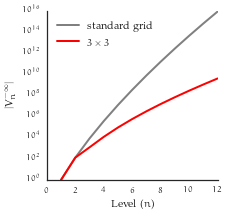

In [23]:
size = figsize(0.5)[0]
size = (size, size)
fig, ax = plt.subplots(figsize=size)
kwargs = {'linewidth': 2}
ax.plot(x,y_sg, color='gray', label='standard grid', **kwargs)
ax.plot(x,y_l2, color='red', label=r'$3 \times 3$', **kwargs)
ax.set_xlabel(r"Level ($n$)")
ax.set_ylabel(r"$\vert V^{-\infty}_n \vert$")
ax.set_yscale('log')
#ax.hlines(3823, 0, 12, colors='black', linestyle='dotted', zorder=-1, **kwargs)
#ax.annotate(r"No.~of training data points", (6, 3823*2))
ax.legend(loc='upper left')
sns.despine(fig)
fig.subplots_adjust(left=.15, bottom=.16, right=.97, top=.97)
fig.savefig("../writing/thesis/figures/interaction_sizes.pdf", transparent=True)


In [18]:
fig_width, fig_height

(5.7874021032240215, 3.5768112063550732)

In [40]:
plt.rcParams['text.latex.preamble']

['\\usepackage[sc, osf]{mathpazo}',
 '\\usepackage[euler-digits,small]{eulervm}',
 '\\usepackage{amsmath}']

In [190]:
num3

Counter({0: 1, 1: 6, 2: 4})

In [191]:
num4

Counter({0: 1, 1: 14, 2: 20, 3: 8})

In [19]:
inter_l2 = mnist_interactions(l2_distance, 2**0.5, 4) + [[]] # add bias
grid, size = get_grid_size(4,0.1, inter_l2)
size

1737

In [20]:
len(set(group_list(grid)))

275

In [6]:
mnist_interactions(l2_distance, 2**0.5, 3)

[[0],
 [0, 1],
 [0, 8],
 [0, 9],
 [1],
 [1, 2],
 [1, 8],
 [1, 9],
 [1, 10],
 [2],
 [2, 3],
 [2, 9],
 [2, 10],
 [2, 11],
 [3],
 [3, 4],
 [3, 10],
 [3, 11],
 [3, 12],
 [4],
 [4, 5],
 [4, 11],
 [4, 12],
 [4, 13],
 [5],
 [5, 6],
 [5, 12],
 [5, 13],
 [5, 14],
 [6],
 [6, 7],
 [6, 13],
 [6, 14],
 [6, 15],
 [7],
 [7, 14],
 [7, 15],
 [8],
 [8, 9],
 [8, 16],
 [8, 17],
 [9],
 [9, 10],
 [9, 16],
 [9, 17],
 [9, 18],
 [10],
 [10, 11],
 [10, 17],
 [10, 18],
 [10, 19],
 [11],
 [11, 12],
 [11, 18],
 [11, 19],
 [11, 20],
 [12],
 [12, 13],
 [12, 19],
 [12, 20],
 [12, 21],
 [13],
 [13, 14],
 [13, 20],
 [13, 21],
 [13, 22],
 [14],
 [14, 15],
 [14, 21],
 [14, 22],
 [14, 23],
 [15],
 [15, 22],
 [15, 23],
 [16],
 [16, 17],
 [16, 24],
 [16, 25],
 [17],
 [17, 18],
 [17, 24],
 [17, 25],
 [17, 26],
 [18],
 [18, 19],
 [18, 25],
 [18, 26],
 [18, 27],
 [19],
 [19, 20],
 [19, 26],
 [19, 27],
 [19, 28],
 [20],
 [20, 21],
 [20, 27],
 [20, 28],
 [20, 29],
 [21],
 [21, 22],
 [21, 28],
 [21, 29],
 [21, 30],
 [22],
 [22, 2